![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/2.Text_Preprocessing_with_SparkNLP_Annotators_Transformers.ipynb)

# **Text Preprocessing with Spark NLP**

**Note** Read this article if you want to understand the basic concepts in Spark NLP.

https://towardsdatascience.com/introduction-to-spark-nlp-foundations-and-basic-components-part-i-c83b7629ed59

## **0. Colab Setup**

In [ ]:
!pip install -q pyspark==3.3.0  spark-nlp==4.3.0

### **1. Annotators and Transformer Concepts**

In Spark NLP, all Annotators are either Estimators or Transformers as we see in Spark ML. An Estimator in Spark ML is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model. A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer that transforms a DataFrame with features into a DataFrame with predictions.
In Spark NLP, there are two types of annotators: AnnotatorApproach and AnnotatorModel
AnnotatorApproach extends Estimators from Spark ML, which are meant to be trained through fit(), and AnnotatorModel extends Transformers which are meant to transform data frames through transform().
Some of Spark NLP annotators have a Model suffix and some do not. The model suffix is explicitly stated when the annotator is the result of a training process. Some annotators, such as Tokenizer are transformers but do not contain the suffix Model since they are not trained, annotators. Model annotators have a pre-trained() on its static object, to retrieve the public pre-trained version of a model.
Long story short, if it trains on a DataFrame and produces a model, it’s an AnnotatorApproach; and if it transforms one DataFrame into another DataFrame through some models, it’s an AnnotatorModel (e.g. WordEmbeddingsModel) and it doesn’t take Model suffix if it doesn’t rely on a pre-trained annotator while transforming a DataFrame (e.g. Tokenizer).

By convention, there are three possible names:

**Approach** — Trainable annotator

**Model** — Trained annotator

**nothing** — Either a non-trainable annotator with pre-processing
step or shorthand for a model

So for example, Stemmer doesn’t say Approach nor Model, however, it is a Model. On the other hand, Tokenizer doesn’t say Approach nor Model, but it has a TokenizerModel(). Because it is not “training” anything, but it is doing some preprocessing before converting into a Model.
When in doubt, please refer to official documentation and API reference.
Even though we will do many hands-on practices in the following articles, let us give you a glimpse to let you understand the difference between AnnotatorApproach and AnnotatorModel.
As stated above, Tokenizer is an AnnotatorModel. So we need to call fit() and then transform().

Now let’s see how this can be done in Spark NLP using Annotators and Transformers. Assume that we have the following steps that need to be applied one by one on a data frame.

- Split text into sentences
- Tokenize
- Normalize
- Get word embeddings

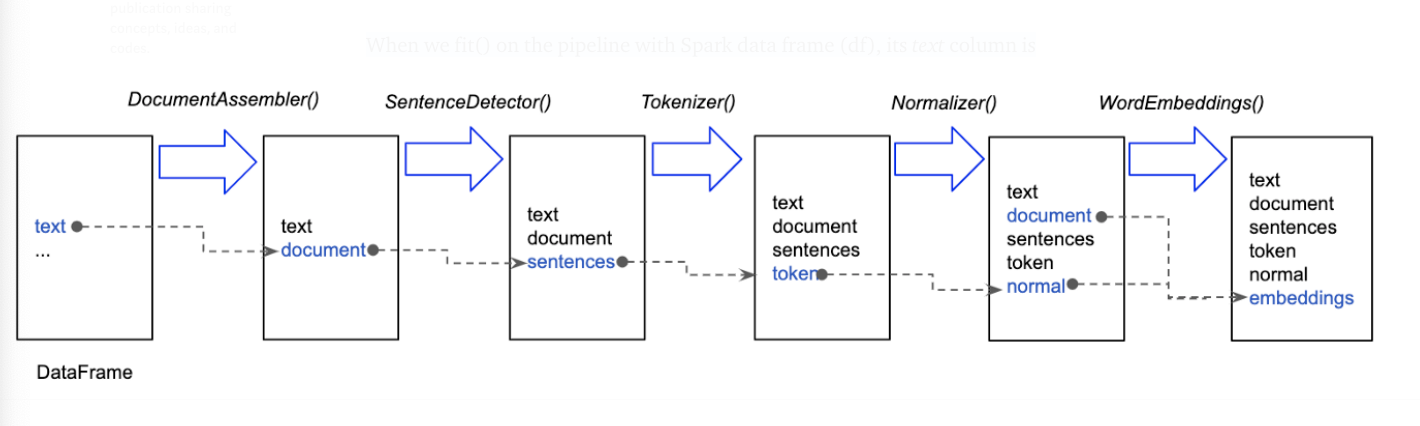

**What’s actually happening under the hood?**

When we fit() on the pipeline with Spark data frame (df), its text column is fed into DocumentAssembler() transformer at first and then a new column “document” is created in Document type (AnnotatorType). As we mentioned before, this transformer is basically the initial entry point to Spark NLP for any Spark data frame. Then its document column is fed into SentenceDetector() (AnnotatorApproach) and the text is split into an array of sentences and a new column “sentences” in Document type is created. Then “sentences” column is fed into Tokenizer() (AnnotatorModel) and each sentence is tokenized and a new column “token” in Token type is created. And so on. 

In [ ]:
import sparknlp

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

Spark NLP version:  4.3.0
Apache Spark version:  3.3.0


### **Create Spark Dataframe**

In [ ]:
text = 'Peter Parker is a nice guy and lives in New York'

spark_df = spark.createDataFrame([[text]]).toDF("text")

spark_df.show(truncate=False)

+------------------------------------------------+
|text                                            |
+------------------------------------------------+
|Peter Parker is a nice guy and lives in New York|
+------------------------------------------------+



In [ ]:
from pyspark.sql.types import StringType, IntegerType

# if you want to create a spark datafarme from a list of strings

text_list = ['Peter Parker is a nice guy and lives in New York.', 'Bruce Wayne is also a nice guy and lives in Gotham City.']

spark.createDataFrame(text_list, StringType()).toDF("text").show(truncate=80)


+--------------------------------------------------------+
|                                                    text|
+--------------------------------------------------------+
|       Peter Parker is a nice guy and lives in New York.|
|Bruce Wayne is also a nice guy and lives in Gotham City.|
+--------------------------------------------------------+



In [ ]:
from pyspark.sql import Row

spark.createDataFrame(list(map(lambda x: Row(text=x), text_list))).show(truncate=80)

+--------------------------------------------------------+
|                                                    text|
+--------------------------------------------------------+
|       Peter Parker is a nice guy and lives in New York.|
|Bruce Wayne is also a nice guy and lives in Gotham City.|
+--------------------------------------------------------+



In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/annotation/english/spark-nlp-basics/sample-sentences-en.txt

In [ ]:
with open('./sample-sentences-en.txt') as f:
  print (f.read())

Peter is a very good person.
My life in Russia is very interesting.
John and Peter are brothers. However they don't support each other that much.
Lucas Nogal Dunbercker is no longer happy. He has a good car though.
Europe is very culture rich. There are huge churches! and big houses!


In [ ]:
spark_df = spark.read.text('./sample-sentences-en.txt').toDF('text')

spark_df.show(truncate=False)

+-----------------------------------------------------------------------------+
|text                                                                         |
+-----------------------------------------------------------------------------+
|Peter is a very good person.                                                 |
|My life in Russia is very interesting.                                       |
|John and Peter are brothers. However they don't support each other that much.|
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.         |
|Europe is very culture rich. There are huge churches! and big houses!        |
+-----------------------------------------------------------------------------+



In [ ]:
spark_df.select('text').show(truncate=False)

+-----------------------------------------------------------------------------+
|text                                                                         |
+-----------------------------------------------------------------------------+
|Peter is a very good person.                                                 |
|My life in Russia is very interesting.                                       |
|John and Peter are brothers. However they don't support each other that much.|
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.         |
|Europe is very culture rich. There are huge churches! and big houses!        |
+-----------------------------------------------------------------------------+



In [ ]:
textFiles = spark.sparkContext.wholeTextFiles("./*.txt",4)
    
spark_df_folder = textFiles.toDF(schema=['path','text'])

spark_df_folder.show(truncate=30)

+------------------------------+------------------------------+
|                          path|                          text|
+------------------------------+------------------------------+
|file:/content/sample-senten...|Peter is a very good person...|
+------------------------------+------------------------------+



In [ ]:
spark_df_folder.select('text').take(1)

[Row(text="Peter is a very good person.\nMy life in Russia is very interesting.\nJohn and Peter are brothers. However they don't support each other that much.\nLucas Nogal Dunbercker is no longer happy. He has a good car though.\nEurope is very culture rich. There are huge churches! and big houses!")]

In [ ]:
spark_df_folder.select('text').collect()

[Row(text="Peter is a very good person.\nMy life in Russia is very interesting.\nJohn and Peter are brothers. However they don't support each other that much.\nLucas Nogal Dunbercker is no longer happy. He has a good car though.\nEurope is very culture rich. There are huge churches! and big houses!")]

### **Transformers**

What are we going to do if our DataFrame doesn’t have columns in those type? Here comes transformers. In Spark NLP, we have five different transformers that are mainly used for getting the data in or transform the data from one AnnotatorType to another. Here is the list of transformers:

| **Transformers**  | **Description** |
| - | - |
|**DocumentAssembler**      |To get through the NLP process, we need to get raw data annotated. This is a special transformer that does this for us; it creates the first annotation of type Document which may be used by annotators down the road.
|**TokenAssembler**      |This transformer reconstructs a Document type annotation from tokens, usually after these have been, lemmatized, normalized, spell checked, etc, to use this document annotation in further annotators.
|**Doc2Chunk**      | Converts DOCUMENT type annotations into CHUNK type with the contents of a chunkCol.
|**Chunk2Doc**      |Converts a CHUNK type column back into DOCUMENT. Useful when trying to re-tokenize or do further analysis on a CHUNK result.
|**Finisher** |Once we have our NLP pipeline ready to go, we might want to use our annotation results somewhere else where it is easy to use. The Finisher outputs annotation(s) values into a string.


Each annotator accepts certain types of columns and outputs new columns in another type (we call this AnnotatorType).

In Spark NLP, we have the following types: 

>`Document`, `token`, `chunk`, `pos`, `word_embeddings`, `date`, `entity`, `sentiment`, `named_entity`, `dependency`, `labeled_dependency`. 

That is, the DataFrame you have needs to have a column from one of these types if that column will be fed into an annotator; otherwise, you’d need to use one of the Spark NLP transformers.

##  **Document Assembler**

In Spark NLP, we have five different transformers that are mainly used for getting the data in or transform the data from one AnnotatorType to another.

That is, the DataFrame you have needs to have a column from one of these types if that column will be fed into an annotator; otherwise, you’d need to use one of the Spark NLP transformers. Here is the list of transformers: DocumentAssembler, TokenAssembler, Doc2Chunk, Chunk2Doc, and the Finisher.

So, let’s start with DocumentAssembler(), an entry point to Spark NLP annotators.

To get through the process in Spark NLP, we need to get raw data transformed into Document type at first. 

DocumentAssembler() is a special transformer that does this for us; it creates the first annotation of type Document which may be used by annotators down the road.

DocumentAssembler() comes from sparknlp.base class and has the following settable parameters. See the full list here and the source code here.


| Parametre  | Value | Description |
| - | - | - |
|**setInputCol()***       |String |The name of the column that will be converted. We can specify only one column here. It can read either a String column or an Array.|
|**setOutputCol()*** |optional|The name of the column in Document type that is generated. We can specify only one column here. Default is '**document**'.|
|**setIdCol()***  |optional|String type column with id information|
|**setMetadataCol()*** |optional|Map type column with metadata information.|
|**setCleanupMode()***|optional| Cleaning up options|


possible values for setCleanupMode :
  ```
  disabled: Source kept as original. This is a default.
  inplace: removes new lines and tabs.
  inplace_full: removes new lines and tabs but also those which were converted to strings (i.e. \n)
  shrink: removes new lines and tabs, plus merging multiple spaces and blank lines to a single space.
  shrink_full: remove new lines and tabs, including stringified values, plus shrinking spaces and blank lines.
  ```

In [ ]:
spark_df.show()

+--------------------+
|                text|
+--------------------+
|Peter is a very g...|
|My life in Russia...|
|John and Peter ar...|
|Lucas Nogal Dunbe...|
|Europe is very cu...|
+--------------------+



In [ ]:
spark_df.show(truncate=False)

+-----------------------------------------------------------------------------+
|text                                                                         |
+-----------------------------------------------------------------------------+
|Peter is a very good person.                                                 |
|My life in Russia is very interesting.                                       |
|John and Peter are brothers. However they don't support each other that much.|
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.         |
|Europe is very culture rich. There are huge churches! and big houses!        |
+-----------------------------------------------------------------------------+



In [ ]:
from sparknlp.base import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")\
    .setCleanupMode("shrink")

doc_df = documentAssembler.transform(spark_df)

doc_df.show(truncate=False)

+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|text                                                                         |document                                                                                                               |
+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|Peter is a very good person.                                                 |[{document, 0, 27, Peter is a very good person., {sentence -> 0}, []}]                                                 |
|My life in Russia is very interesting.                                       |[{document, 0, 37, My life in Russia is very interesting., {sentence -> 0}, []}]                                       |


At first, we define DocumentAssembler with desired parameters and then transform the data frame with it. The most important point to pay attention to here is that you need to use a String or String[Array] type column in .setInputCol(). So it doesn’t have to be named as text. You just use the column name as it is.

In [ ]:
doc_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)



In [ ]:
doc_df.select('document.result','document.begin','document.end').show(truncate=False)

+-------------------------------------------------------------------------------+-----+----+
|result                                                                         |begin|end |
+-------------------------------------------------------------------------------+-----+----+
|[Peter is a very good person.]                                                 |[0]  |[27]|
|[My life in Russia is very interesting.]                                       |[0]  |[37]|
|[John and Peter are brothers. However they don't support each other that much.]|[0]  |[76]|
|[Lucas Nogal Dunbercker is no longer happy. He has a good car though.]         |[0]  |[67]|
|[Europe is very culture rich. There are huge churches! and big houses!]        |[0]  |[68]|
+-------------------------------------------------------------------------------+-----+----+



The new column is in an array of struct type and has the parameters shown above. The annotators and transformers all come with universal metadata that would be filled down the road depending on the annotators being used. Unless you want to append other Spark NLP annotators to DocumentAssembler(), you don’t need to know what all these parameters mean for now. So we will talk about them in the following articles. You can access all these parameters with {column name}.{parameter name}.

Let’s print out the first item’s result.

In [ ]:
doc_df.select("document.result").take(1)

[Row(result=['Peter is a very good person.'])]

If we would like to flatten the document column, we can do as follows.


In [ ]:
import pyspark.sql.functions as F

doc_df.withColumn(
    "tmp", 
    F.explode("document"))\
    .select("tmp.*")\
    .show(truncate=False)

+-------------+-----+---+-----------------------------------------------------------------------------+---------------+----------+
|annotatorType|begin|end|result                                                                       |metadata       |embeddings|
+-------------+-----+---+-----------------------------------------------------------------------------+---------------+----------+
|document     |0    |27 |Peter is a very good person.                                                 |{sentence -> 0}|[]        |
|document     |0    |37 |My life in Russia is very interesting.                                       |{sentence -> 0}|[]        |
|document     |0    |76 |John and Peter are brothers. However they don't support each other that much.|{sentence -> 0}|[]        |
|document     |0    |67 |Lucas Nogal Dunbercker is no longer happy. He has a good car though.         |{sentence -> 0}|[]        |
|document     |0    |68 |Europe is very culture rich. There are huge churches! and 

## **Sentence Detector**

Finds sentence bounds in raw text. 

| Parametre  | Value | Description |
| - | - | - |
|**setCustomBounds()***       |String |Custom sentence separator text e.g. `["\n"]`|
|**setUseCustomOnly()*** |Bool|Use only custom bounds without considering those of Pragmatic Segmenter. Defaults to false. Needs customBounds.|
|**setUseAbbreviations***  |Bool| Whether to consider abbreviation strategies for better accuracy but slower performance. Defaults to true.|
|**setExplodeSentences*** |Bool|Whether to split sentences into different Dataset rows. Useful for higher parallelism in fat rows. Defaults to false.|


In [ ]:
from sparknlp.annotator import *

# we feed the document column coming from Document Assembler

sentenceDetector = SentenceDetector()\
      .setInputCols(['document'])\
      .setOutputCol('sentences')

In [ ]:
sentenceDetector.extractParamMap()

{Param(parent='SentenceDetector_176a5418c081', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='SentenceDetector_176a5418c081', name='useAbbreviations', doc='whether to apply abbreviations at sentence detection'): True,
 Param(parent='SentenceDetector_176a5418c081', name='detectLists', doc='whether detect lists during sentence detection'): True,
 Param(parent='SentenceDetector_176a5418c081', name='useCustomBoundsOnly', doc='Only utilize custom bounds in sentence detection'): False,
 Param(parent='SentenceDetector_176a5418c081', name='customBounds', doc='characters used to explicitly mark sentence bounds'): [],
 Param(parent='SentenceDetector_176a5418c081', name='customBoundsStrategy', doc='How to return matched custom bounds'): 'none',
 Param(parent='SentenceDetector_176a5418c081', name='explodeSentences', doc='whether to explode each sentence into a different row, for better parallelization. Defaults to false.'): False,

In [ ]:
doc_df.show(truncate=False)

+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|text                                                                         |document                                                                                                               |
+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|Peter is a very good person.                                                 |[{document, 0, 27, Peter is a very good person., {sentence -> 0}, []}]                                                 |
|My life in Russia is very interesting.                                       |[{document, 0, 37, My life in Russia is very interesting., {sentence -> 0}, []}]                                       |


In [ ]:
sent_df = sentenceDetector.transform(doc_df)

sent_df.show(truncate=False)

+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                         |document                                                                                                               |sentences                                                                                                                                                                                          |
+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+---------

In [ ]:
sent_df.select('sentences').take(3)

[Row(sentences=[Row(annotatorType='document', begin=0, end=27, result='Peter is a very good person.', metadata={'sentence': '0'}, embeddings=[])]),
 Row(sentences=[Row(annotatorType='document', begin=0, end=37, result='My life in Russia is very interesting.', metadata={'sentence': '0'}, embeddings=[])]),
 Row(sentences=[Row(annotatorType='document', begin=0, end=27, result='John and Peter are brothers.', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='document', begin=29, end=76, result="However they don't support each other that much.", metadata={'sentence': '1'}, embeddings=[])])]

In [ ]:
sent_df.select('sentences.result').take(3)

[Row(result=['Peter is a very good person.']),
 Row(result=['My life in Russia is very interesting.']),
 Row(result=['John and Peter are brothers.', "However they don't support each other that much."])]

In [ ]:
sent_df.select('sentences.metadata').take(3)

[Row(metadata=[{'sentence': '0'}]),
 Row(metadata=[{'sentence': '0'}]),
 Row(metadata=[{'sentence': '0'}, {'sentence': '1'}])]

In [ ]:
text ='The patient was prescribed 1 capsule of Advil for 5 days. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months.'
text


'The patient was prescribed 1 capsule of Advil for 5 days. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months.'

In [ ]:
spark_df = spark.createDataFrame([[text]]).toDF("text")

spark_df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
spark_df.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The patient was prescribed 1 capsule of Advil f...|
+--------------------------------------------------+



In [ ]:
doc_df = documentAssembler.transform(spark_df)

sent_df = sentenceDetector.transform(doc_df)

sent_df.show(truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                              text|                                          document|                                         sentences|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|The patient was prescribed 1 capsule of Advil f...|[{document, 0, 334, The patient was prescribed ...|[{document, 0, 56, The patient was prescribed 1...|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+



In [ ]:
sent_df.select('sentences.result').take(1)

[Row(result=['The patient was prescribed 1 capsule of Advil for 5 days.', 'He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day.', 'It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months.'])]

In [ ]:
# setExplodeSentences: Whether to split sentences into different Dataset rows. Useful for higher parallelism in fat rows. Defaults to false.

sentenceDetector.setExplodeSentences(True)

SentenceDetector_176a5418c081

In [ ]:
sent_df = sentenceDetector.transform(doc_df)

sent_df.show(truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                              text|                                          document|                                         sentences|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|The patient was prescribed 1 capsule of Advil f...|[{document, 0, 334, The patient was prescribed ...|[{document, 0, 56, The patient was prescribed 1...|
|The patient was prescribed 1 capsule of Advil f...|[{document, 0, 334, The patient was prescribed ...|[{document, 58, 240, He was seen by the endocri...|
|The patient was prescribed 1 capsule of Advil f...|[{document, 0, 334, The patient was prescribed ...|[{document, 242, 334, It was determined that al...|
+--------------------------------------------------+------------------

In [ ]:
sent_df.select('sentences.result').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[The patient was prescribed 1 capsule of Advil for 5 days.]                                                                                                                              |
|[He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day.]|
|[It was determined that all SGLT2 inhibitors should be disc

In [ ]:
from pyspark.sql import functions as F

sent_df.select(F.explode('sentences.result')).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|col                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|The patient was prescribed 1 capsule of Advil for 5 days.                                                                                                                              |
|He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day.|
|It was determined that all SGLT2 inhibitors should be discontinued in

**`.setCustomBounds([r"\\.", ";"])`**

**`.setCustomBoundsStrategy("append")`**


In [ ]:
text = [
    ["Peter is a very good person."],
    ["My life in Russia is very interesting."], 
    ["John and Peter are brothers. However; they don't support each other that much."],
    ["Lucas Nogal Dunbercker is no longer happy. He has a good car though."],
    ["Europe is very culture rich. There are huge churches! and big houses!"]
    ]

In [ ]:
spark_df = spark.createDataFrame(text).toDF("text")
spark_df.show(truncate=False)

+------------------------------------------------------------------------------+
|text                                                                          |
+------------------------------------------------------------------------------+
|Peter is a very good person.                                                  |
|My life in Russia is very interesting.                                        |
|John and Peter are brothers. However; they don't support each other that much.|
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.          |
|Europe is very culture rich. There are huge churches! and big houses!         |
+------------------------------------------------------------------------------+



In [ ]:
doc_df = documentAssembler.transform(spark_df)

In [ ]:
sentenceDetector = SentenceDetector()\
      .setInputCols(['document'])\
      .setOutputCol('sentences')\
      .setCustomBounds([r"\.", ";", "!"])\
      .setCustomBoundsStrategy("append")
      
sent_df = sentenceDetector.transform(doc_df)
sent_df.show(truncate=False)

+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                          |document                                                                                                                |sentences                                                                                                                                                                                                   |
+------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------

In [ ]:
sent_df.select('sentences.result').take(5)

[Row(result=['Peter is a very good person.']),
 Row(result=['My life in Russia is very interesting.']),
 Row(result=['John and Peter are brothers.', 'However;', "they don't support each other that much."]),
 Row(result=['Lucas Nogal Dunbercker is no longer happy.', 'He has a good car though.']),
 Row(result=['Europe is very culture rich.', 'There are huge churches!', 'and big houses!'])]

**`.setCustomBoundsStrategy("prepend")`**

In [ ]:
sentenceDetector = SentenceDetector()\
      .setInputCols(['document'])\
      .setOutputCol('sentences')\
      .setCustomBounds([r"\.", ";", "!"])\
      .setCustomBoundsStrategy("prepend")

sent_df = sentenceDetector.transform(doc_df)
sent_df.show(truncate=False)

+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                          |document                                                                                                                |sentences                                                                                                                                                                                                                                                              

In [ ]:
sent_df.select('sentences.result').take(5)

[Row(result=['Peter is a very good person', '.']),
 Row(result=['My life in Russia is very interesting', '.']),
 Row(result=['John and Peter are brothers', '.', 'However', ';', "they don't support each other that much", '.']),
 Row(result=['Lucas Nogal Dunbercker is no longer happy', '.', 'He has a good car though', '.']),
 Row(result=['Europe is very culture rich', '.', 'There are huge churches', '!', 'and big houses', '!'])]

The separation of the sentences is determined according to the characters we set with custom bound. When we use `append`, sentences are differentiated according to the characters, if `prepend` is used, it also determines the characters as separate sentences.

### **Sentence Detector DL**

In [ ]:
text ='The patient was prescribed 1 capsule of Advil for 5 days. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months.'

spark_df = spark.createDataFrame([[text]]).toDF("text")

doc_df = documentAssembler.transform(spark_df)

In [ ]:
sentencerDL = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")\

sent_dl_df = sentencerDL.transform(doc_df)

sent_dl_df.select(F.explode('sentences.result')).show(truncate=False)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|col                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|The patient was prescribed 1 capsule of Advil for 5 days.                                                                                                                              |
|He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night, 12 units of insulin lispro with meals, and

In [ ]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')\
    
sentencerDL = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")


sd_pipeline = PipelineModel(stages=[documenter, sentenceDetector])
sd_model = LightPipeline(sd_pipeline)


# DL version
sd_dl_pipeline = PipelineModel(stages=[documenter, sentencerDL])
sd_dl_model = LightPipeline(sd_dl_pipeline)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [ ]:
text = """John loves Mary.Mary loves Peter
Peter loves Helen .Helen loves John; 
Total: four people involved."""

# sd_model
for anno in sd_model.fullAnnotate(text)[0]["sentences"]:
    print("{}\t{}\t{}\t{}".format(
        anno.metadata["sentence"], anno.begin, anno.end, anno.result))

0	0	51	John loves Mary.Mary loves Peter
Peter loves Helen .
1	52	68	Helen loves John;
2	71	98	Total: four people involved.


In [ ]:
# sd_dl_model
for anno in sd_dl_model.fullAnnotate(text)[0]["sentences"]:
    print("{}\t{}\t{}\t{}".format(
        anno.metadata["sentence"], anno.begin, anno.end, anno.result))

0	0	15	John loves Mary.
1	16	31	Mary loves Peter
2	33	51	Peter loves Helen .
3	52	68	Helen loves John;
4	71	98	Total: four people involved.


## Tokenizer

Identifies tokens with tokenization open standards. It is an **Annotator Approach, so it requires .fit()**.

A few rules will help customizing it if defaults do not fit user needs.

setExceptions(StringArray): List of tokens to not alter at all. Allows composite tokens like two worded tokens that the user may not want to split.

| Parametre  | Value | Description |
| - | - | - |
|**addException()***       |String |Add a single exception.|
|**setExceptionsPath()*** |String|Path to txt file with list of token exceptions.|
|**caseSensitiveExceptions***  |Bool| Whether to follow case sensitiveness for matching exceptions in text.|
|**contextChars()*** |StringArray|List of 1 character string to rip off from tokens, such as parenthesis or question marks. Ignored if using prefix, infix or suffix patterns.|
|**splitChars()*** |StringArray|List of 1 character string to split tokens inside, such as hyphens. Ignored if using infix, prefix or suffix patterns.|
|**splitPattern()*** |String|pattern to separate from the inside of tokens. takes priority over splitChars. setTargetPattern: Basic regex rule to identify a candidate for tokenization. Defaults to \S+ which means anything not a space.|
|**setSuffixPattern()*** ||Regex to identify subtokens that are in the end of the token. Regex has to end with \z and must contain groups (). Each group will become a separate token within the prefix. Defaults to non-letter characters. e.g. quotes or parenthesis|
|**setPrefixPattern()*** ||Regex to identify subtokens that come in the beginning of the token. Regex has to start with \A and must contain groups (). Each group will become a separate token within the prefix. Defaults to non-letter characters. e.g. quotes or parenthesis.|
|**addInfixPattern()*** ||Add an extension pattern regex with groups to the top of the rules (will target first, from more specific to the more general).|
|**minLength()*** ||Set the minimum allowed legth for each token.|
|**maxLength()*** ||Set the maximum allowed legth for each token.|




In [ ]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

In [ ]:
tokenizer.extractParamMap()

{Param(parent='Tokenizer_6d8479c7cd62', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='Tokenizer_6d8479c7cd62', name='targetPattern', doc='pattern to grab from text as token candidates. Defaults \\S+'): '\\S+',
 Param(parent='Tokenizer_6d8479c7cd62', name='contextChars', doc='character list used to separate from token boundaries'): ['.',
  ',',
  ';',
  ':',
  '!',
  '?',
  '*',
  '-',
  '(',
  ')',
  '"',
  "'"],
 Param(parent='Tokenizer_6d8479c7cd62', name='caseSensitiveExceptions', doc='Whether to care for case sensitiveness in exceptions'): True,
 Param(parent='Tokenizer_6d8479c7cd62', name='minLength', doc='Set the minimum allowed length for each token'): 0,
 Param(parent='Tokenizer_6d8479c7cd62', name='maxLength', doc='Set the maximum allowed length for each token'): 99999,
 Param(parent='Tokenizer_6d8479c7cd62', name='inputCols', doc='previous annotations columns, if renamed'): ['document'],
 Param(parent='Token

In [ ]:
text = 'Peter Parker (Spiderman) is a nice guy and lives in New York but has no e-mail!'

spark_df = spark.createDataFrame([[text]]).toDF("text")

In [ ]:
doc_df = documentAssembler.transform(spark_df)

token_df = tokenizer.fit(doc_df).transform(doc_df)

token_df.show(truncate=100)

+-------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                           text|                                                                                            document|                                                                                               token|
+-------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Peter Parker (Spiderman) is a nice guy and lives in New York but has no e-mail!|[{document, 0, 78, Peter Parker (Spiderman) is a nice guy and lives

In [ ]:
token_df.select('token.result').take(1)

[Row(result=['Peter', 'Parker', '(', 'Spiderman', ')', 'is', 'a', 'nice', 'guy', 'and', 'lives', 'in', 'New', 'York', 'but', 'has', 'no', 'e-mail', '!'])]

In [ ]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['?', '!']) \
    .addException("New York") \

In [ ]:
token_df = tokenizer.fit(doc_df).transform(doc_df)

token_df.select('token.result').take(1)

[Row(result=['Peter', 'Parker', '(Spiderman)', 'is', 'a', 'nice', 'guy', 'and', 'lives', 'in', 'New York', 'but', 'has', 'no', 'e', 'mail', '!'])]

## Regex Tokenizer

In [ ]:
from pyspark.sql.types import StringType

content = "1. T1-T2 DATE**[12/24/13] $1.99 () (10/12), ph+ 90%"
pattern = "\\s+|(?=[-.:;*+,$&%\\[\\]])|(?<=[-.:;*+,$&%\\[\\]])"

df = spark.createDataFrame([content], StringType()).withColumnRenamed("value", "text")

documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

regexTokenizer = RegexTokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("regexToken") \
    .setPattern(pattern) \
    .setPositionalMask(False)

docPatternRemoverPipeline = Pipeline().setStages([documenter,
                                                  sentenceDetector,
                                                  regexTokenizer])

result = docPatternRemoverPipeline.fit(df).transform(df)
result.show(truncate=False)

+---------------------------------------------------+---------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pyspark.sql.functions as F

result_df = result.select(F.explode(result.regexToken.result).alias('regexToken')).toPandas()
result_df

,regexToken
0,1
1,.
2,T1
3,-
4,T2
5,DATE
6,*
7,*
8,[
9,12/24/13


## Stacking Spark NLP Annotators in Spark ML Pipeline

Spark NLP provides an easy API to integrate with Spark ML Pipelines and all the Spark NLP annotators and transformers can be used within Spark ML Pipelines. So, it’s better to explain Pipeline concept through Spark ML official documentation.

What is a Pipeline anyway? In machine learning, it is common to run a sequence of algorithms to process and learn from data. 

Apache Spark ML represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order.

In simple terms, a pipeline chains multiple Transformers and Estimators together to specify an ML workflow. We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow.

The figure below is for the training time usage of a Pipeline.

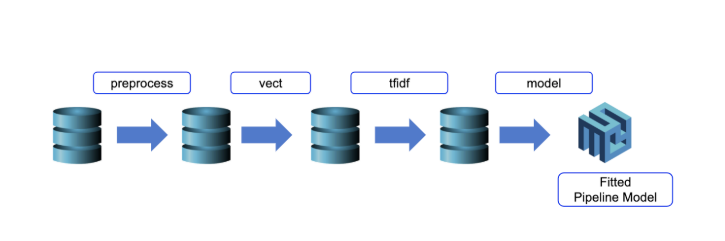

A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator. These stages are run in order, and the input DataFrame is transformed as it passes through each stage. That is, the data are passed through the fitted pipeline in order. Each stage’s transform() method updates the dataset and passes it to the next stage. With the help of Pipelines, we can ensure that training and test data go through identical feature processing steps.

Now let’s see how this can be done in Spark NLP using Annotators and Transformers. Assume that we have the following steps that need to be applied one by one on a data frame.

- Split text into sentences
- Tokenize

And here is how we code this pipeline up in Spark NLP.

In [ ]:
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("token")

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               sentenceDetector,
                               tokenizer])

spark_df = spark.read.text('./sample-sentences-en.txt').toDF('text')

pipelineModel = nlpPipeline.fit(spark_df)

In [ ]:
spark_df = spark.read.text('./sample-sentences-en.txt').toDF('text')

spark_df.show(truncate=False)

+-----------------------------------------------------------------------------+
|text                                                                         |
+-----------------------------------------------------------------------------+
|Peter is a very good person.                                                 |
|My life in Russia is very interesting.                                       |
|John and Peter are brothers. However they don't support each other that much.|
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.         |
|Europe is very culture rich. There are huge churches! and big houses!        |
+-----------------------------------------------------------------------------+



In [ ]:
result = pipelineModel.transform(spark_df)

In [ ]:
result.show(truncate=40)

+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|                                    text|                                document|                               sentences|                                   token|
+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|            Peter is a very good person.|[{document, 0, 27, Peter is a very go...|[{document, 0, 27, Peter is a very go...|[{token, 0, 4, Peter, {sentence -> 0}...|
|  My life in Russia is very interesting.|[{document, 0, 37, My life in Russia ...|[{document, 0, 37, My life in Russia ...|[{token, 0, 1, My, {sentence -> 0}, [...|
|John and Peter are brothers. However ...|[{document, 0, 76, John and Peter are...|[{document, 0, 27, John and Peter are...|[{token, 0, 3, John, {sentence -> 0},...|
|Luc

In [ ]:
result.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = tru

In [ ]:
result.select('sentences.result').take(3)

[Row(result=['Peter is a very good person.']),
 Row(result=['My life in Russia is very interesting.']),
 Row(result=['John and Peter are brothers.', "However they don't support each other that much."])]

In [ ]:
result.select('token').take(3)[2]

Row(token=[Row(annotatorType='token', begin=0, end=3, result='John', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=5, end=7, result='and', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=9, end=13, result='Peter', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=15, end=17, result='are', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=19, end=26, result='brothers', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=27, end=27, result='.', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=29, end=35, result='However', metadata={'sentence': '1'}, embeddings=[]), Row(annotatorType='token', begin=37, end=40, result='they', metadata={'sentence': '1'}, embeddings=[]), Row(annotatorType='token', begin=42, end=46, result="don't", metadata={'sentence': '1'}, embeddings=[]), Row(annotatorType='token', begin=48, end=54, result='s

## Normalizer

Removes all dirty characters from text following a regex pattern and transforms words based on a provided dictionary

`setCleanupPatterns(patterns)`: Regular expressions list for normalization, defaults [^A-Za-z]

`setLowercase(value)`: lowercase tokens, default false

`setSlangDictionary(path)`: txt file with delimited words to be transformed into something else


In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               tokenizer,
                               normalizer])

result = nlpPipeline.fit(spark_df).transform(spark_df)

In [ ]:
nlpPipeline.fit(spark_df).stages

[DocumentAssembler_d4926309c3ee,
 REGEX_TOKENIZER_a4789e51e51c,
 NORMALIZER_81bbdb7b0bdb]

In [ ]:
result.show(truncate=40)

+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|                                    text|                                document|                                   token|                              normalized|
+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|            Peter is a very good person.|[{document, 0, 27, Peter is a very go...|[{token, 0, 4, Peter, {sentence -> 0}...|[{token, 0, 4, peter, {sentence -> 0}...|
|  My life in Russia is very interesting.|[{document, 0, 37, My life in Russia ...|[{token, 0, 1, My, {sentence -> 0}, [...|[{token, 0, 1, my, {sentence -> 0}, [...|
|John and Peter are brothers. However ...|[{document, 0, 76, John and Peter are...|[{token, 0, 3, John, {sentence -> 0},...|[{token, 0, 3, john, {sentence -> 0},...|
|Luc

In [ ]:
result.select('token').take(2)

[Row(token=[Row(annotatorType='token', begin=0, end=4, result='Peter', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=6, end=7, result='is', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=9, end=9, result='a', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=11, end=14, result='very', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=16, end=19, result='good', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=21, end=26, result='person', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=27, end=27, result='.', metadata={'sentence': '0'}, embeddings=[])]),
 Row(token=[Row(annotatorType='token', begin=0, end=1, result='My', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=3, end=6, result='life', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=8, end=9, result='in',

In [ ]:
result.select('normalized.result').take(2)

[Row(result=['peter', 'is', 'a', 'very', 'good', 'person']),
 Row(result=['my', 'life', 'in', 'russia', 'is', 'very', 'interesting'])]

In [ ]:
result.select('normalized').take(2)

[Row(normalized=[Row(annotatorType='token', begin=0, end=4, result='peter', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=6, end=7, result='is', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=9, end=9, result='a', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=11, end=14, result='very', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=16, end=19, result='good', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=21, end=26, result='person', metadata={'sentence': '0'}, embeddings=[])]),
 Row(normalized=[Row(annotatorType='token', begin=0, end=1, result='my', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=3, end=6, result='life', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=8, end=9, result='in', metadata={'sentence': '0'}, embeddings=[]), Row(annotatorType='token', begin=11, end=16, r

## Document Normalizer

The DocumentNormalizer is an annotator that can be used after the DocumentAssembler to narmalize documents once that they have been processed and indexed .
It takes in input annotated documents of type Array AnnotatorType.DOCUMENT and gives as output annotated document of type AnnotatorType.DOCUMENT .

Parameters are:  

| Parametre   | Description |
| - | - |
|**inputCol**      |input column name string which targets a column of type Array(AnnotatorType.DOCUMENT).|
|**outputCol**      |output column name string which targets a column of type AnnotatorType.DOCUMENT.|
|**action** |action string to perform applying regex patterns, i.e. (clean | extract). Default is "clean".|
|**cleanupPatterns**  |normalization regex patterns which match will be removed from document. Default is "<[^>]*>" (e.g., it removes all HTML tags).|
|**replacement** |replacement string to apply when regexes match. Default is " ".|
|**lowercase** |whether to convert strings to lowercase. Default is False.|
|**removalPolicy** |removalPolicy to remove patterns from text with a given policy. Valid policy values are: "all", "pretty_all", "first", "pretty_first". Defaults is "pretty_all". |
|**encoding** |file encoding to apply on normalized documents. Supported encodings are: UTF_8, UTF_16, US_ASCII, ISO-8859-1, UTF-16BE, UTF-16LE. Default is "UTF-8".|


In [ ]:
text = '''
  <div id="theworldsgreatest" class='my-right my-hide-small my-wide toptext' style="font-family:'Segoe UI',Arial,sans-serif">
    THE WORLD'S LARGEST WEB DEVELOPER SITE
    <h1 style="font-size:300%;">THE WORLD'S LARGEST WEB DEVELOPER SITE</h1>
    <p style="font-size:160%;">Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum..</p>
  </div>

</div>'''

In [ ]:
spark_df = spark.createDataFrame([[text]]).toDF("text")

spark_df.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                

In [ ]:
documentNormalizer = DocumentNormalizer() \
    .setInputCols("document") \
    .setOutputCol("normalizedDocument")

documentNormalizer.extractParamMap()

{Param(parent='DocumentNormalizer_99e443833d62', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='DocumentNormalizer_99e443833d62', name='action', doc='action to perform applying regex patterns on text'): 'clean',
 Param(parent='DocumentNormalizer_99e443833d62', name='patterns', doc='normalization regex patterns which match will be removed from document. Defaults is <[^>]*>'): ['<[^>]*>'],
 Param(parent='DocumentNormalizer_99e443833d62', name='replacement', doc='replacement string to apply when regexes match'): ' ',
 Param(parent='DocumentNormalizer_99e443833d62', name='lowercase', doc='whether to convert strings to lowercase'): False,
 Param(parent='DocumentNormalizer_99e443833d62', name='policy', doc='policy to remove pattern from text'): 'pretty_all',
 Param(parent='DocumentNormalizer_99e443833d62', name='encoding', doc='file encoding to apply on normalized documents'): 'UTF-8',
 Param(parent='DocumentNormalizer_99e44

In [ ]:
documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

#default
cleanUpPatterns = ["<[^>]*>"]

documentNormalizer = DocumentNormalizer() \
    .setInputCols("document") \
    .setOutputCol("normalizedDocument") \
    .setAction("clean") \
    .setPatterns(cleanUpPatterns) \
    .setReplacement(" ") \
    .setPolicy("pretty_all") \
    .setLowercase(True)

docPatternRemoverPipeline = Pipeline() \
    .setStages([documentAssembler,
                documentNormalizer])
    
pipelineModel = docPatternRemoverPipeline.fit(spark_df).transform(spark_df)

In [ ]:
pipelineModel.select('normalizedDocument.result').show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                                                                                                              

 for more examples : https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/annotation/english/document-normalizer/document_normalizer_notebook.ipynb

## Stopwords Cleaner

This annotator excludes from a sequence of strings (e.g. the output of a Tokenizer, Normalizer, Lemmatizer, and Stemmer) and drops all the stop words from the input sequences.

**Functions**:

| Parametre   | Description |
| - | - |
|**setStopWords**      |The words to be filtered out. Array[String]|
|**setCaseSensitive**      |Whether to do a case sensitive comparison over the stop words.|


In [ ]:
stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("token")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)\
    #.setStopWords(["no", "without"]) (e.g. read a list of words from a txt)

In [ ]:
stopwords_cleaner.getStopWords()

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               tokenizer,
                               stopwords_cleaner])
 
spark_df = spark.read.text('./sample-sentences-en.txt').toDF('text')

result = nlpPipeline.fit(spark_df).transform(spark_df)

result.show(truncate=40)

+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|                                    text|                                document|                                   token|                             cleanTokens|
+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|            Peter is a very good person.|[{document, 0, 27, Peter is a very go...|[{token, 0, 4, Peter, {sentence -> 0}...|[{token, 0, 4, Peter, {sentence -> 0}...|
|  My life in Russia is very interesting.|[{document, 0, 37, My life in Russia ...|[{token, 0, 1, My, {sentence -> 0}, [...|[{token, 3, 6, life, {sentence -> 0},...|
|John and Peter are brothers. However ...|[{document, 0, 76, John and Peter are...|[{token, 0, 3, John, {sentence -> 0},...|[{token, 0, 3, John, {sentence -> 0},...|
|Luc

In [ ]:
result.select('cleanTokens.result').take(1)

[Row(result=['Peter', 'good', 'person', '.'])]

## Token Assembler

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(False)\

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)\

tokenassembler = TokenAssembler()\
    .setInputCols(["sentences", "cleanTokens"]) \
    .setOutputCol("clean_text")


nlpPipeline = Pipeline(stages=[documentAssembler,
                               sentenceDetector,
                               tokenizer,
                               normalizer,
                               stopwords_cleaner,
                               tokenassembler])

result = nlpPipeline.fit(spark_df).transform(spark_df)
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|           sentences|               token|          normalized|         cleanTokens|          clean_text|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Peter is a very g...|[{document, 0, 27...|[{document, 0, 27...|[{token, 0, 4, Pe...|[{token, 0, 4, Pe...|[{token, 0, 4, Pe...|[{document, 0, 16...|
|My life in Russia...|[{document, 0, 37...|[{document, 0, 37...|[{token, 0, 1, My...|[{token, 0, 1, My...|[{token, 3, 6, li...|[{document, 0, 22...|
|John and Peter ar...|[{document, 0, 76...|[{document, 0, 27...|[{token, 0, 3, Jo...|[{token, 0, 3, Jo...|[{token, 0, 3, Jo...|[{document, 0, 18...|
|Lucas Nogal Dunbe...|[{document, 0, 67...|[{document, 0, 41...|[{token, 0, 4, Lu...|[{token, 0, 4, Lu...|

In [ ]:
# if we use TokenAssembler().setPreservePosition(True), the original borders will be preserved (dropped & unwanted chars will be replaced by spaces)

result.select('clean_text').take(1)

[Row(clean_text=[Row(annotatorType='document', begin=0, end=16, result='Peter good person', metadata={'sentence': '0'}, embeddings=[])])]

In [ ]:
result.select('text', F.explode(result.clean_text.result).alias('clean_text')).show(truncate=False)

+-----------------------------------------------------------------------------+-----------------------------------+
|text                                                                         |clean_text                         |
+-----------------------------------------------------------------------------+-----------------------------------+
|Peter is a very good person.                                                 |Peter good person                  |
|My life in Russia is very interesting.                                       |life Russia interesting            |
|John and Peter are brothers. However they don't support each other that much.|John Peter brothers                |
|John and Peter are brothers. However they don't support each other that much.|However dont support much          |
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.         |Lucas Nogal Dunbercker longer happy|
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.   

In [ ]:
result.select('text', F.explode(result.clean_text.result).alias('clean_text')).toPandas()

,text,clean_text
0,Peter is a very good person.,Peter good person
1,My life in Russia is very interesting.,life Russia interesting
2,John and Peter are brothers. However they don'...,John Peter brothers
3,John and Peter are brothers. However they don'...,However dont support much
4,Lucas Nogal Dunbercker is no longer happy. He ...,Lucas Nogal Dunbercker longer happy
5,Lucas Nogal Dunbercker is no longer happy. He ...,good car though
6,Europe is very culture rich. There are huge ch...,Europe culture rich
7,Europe is very culture rich. There are huge ch...,huge churches
8,Europe is very culture rich. There are huge ch...,big houses


In [ ]:
import pyspark.sql.functions as F

result.withColumn(
    "tmp", 
    F.explode("clean_text")) \
    .select("tmp.*").select("begin","end","result","metadata.sentence").show(truncate = False)

+-----+---+-----------------------------------+--------+
|begin|end|result                             |sentence|
+-----+---+-----------------------------------+--------+
|0    |16 |Peter good person                  |0       |
|0    |22 |life Russia interesting            |0       |
|0    |18 |John Peter brothers                |0       |
|29   |53 |However dont support much          |1       |
|0    |34 |Lucas Nogal Dunbercker longer happy|0       |
|43   |57 |good car though                    |1       |
|0    |18 |Europe culture rich                |0       |
|29   |41 |huge churches                      |1       |
|54   |63 |big houses                         |2       |
+-----+---+-----------------------------------+--------+



In [ ]:
# if we hadn't used Sentence Detector, this would be what we got. (tokenizer gets document instead of sentences column)

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

tokenassembler = TokenAssembler()\
    .setInputCols(["document", "cleanTokens"]) \
    .setOutputCol("clean_text")

nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               normalizer,
                               stopwords_cleaner,
                               tokenassembler])

result = nlpPipeline.fit(spark_df).transform(spark_df)
result.select('text', 'clean_text.result').show(truncate=False)

+-----------------------------------------------------------------------------+-----------------------------------------------------+
|text                                                                         |result                                               |
+-----------------------------------------------------------------------------+-----------------------------------------------------+
|Peter is a very good person.                                                 |[Peter good person]                                  |
|My life in Russia is very interesting.                                       |[life Russia interesting]                            |
|John and Peter are brothers. However they don't support each other that much.|[John Peter brothers However dont support much]      |
|Lucas Nogal Dunbercker is no longer happy. He has a good car though.         |[Lucas Nogal Dunbercker longer happy good car though]|
|Europe is very culture rich. There are huge churches! and big

In [ ]:
result.withColumn(
    "tmp", 
    F.explode("clean_text")) \
    .select("tmp.*").select("begin","end","result","metadata.sentence").show(truncate = False)

+-----+---+---------------------------------------------------+--------+
|begin|end|result                                             |sentence|
+-----+---+---------------------------------------------------+--------+
|0    |16 |Peter good person                                  |0       |
|0    |22 |life Russia interesting                            |0       |
|0    |44 |John Peter brothers However dont support much      |0       |
|0    |50 |Lucas Nogal Dunbercker longer happy good car though|0       |
|0    |43 |Europe culture rich huge churches big houses       |0       |
+-----+---+---------------------------------------------------+--------+



**IMPORTANT NOTE:**

If you have some other steps & annotators in your pipeline that will need to use the tokens from cleaned text (assembled tokens), you will need to tokenize the processed text again as the original text is probably changed completely.

## Stemmer

Returns hard-stems out of words with the objective of retrieving the meaningful part of the word


In [ ]:
stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               tokenizer,
                               stemmer])

result = nlpPipeline.fit(spark_df).transform(spark_df)

result.show(truncate=40)

+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|                                    text|                                document|                                   token|                                    stem|
+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+
|            Peter is a very good person.|[{document, 0, 27, Peter is a very go...|[{token, 0, 4, Peter, {sentence -> 0}...|[{token, 0, 4, peter, {sentence -> 0}...|
|  My life in Russia is very interesting.|[{document, 0, 37, My life in Russia ...|[{token, 0, 1, My, {sentence -> 0}, [...|[{token, 0, 1, my, {sentence -> 0}, [...|
|John and Peter are brothers. However ...|[{document, 0, 76, John and Peter are...|[{token, 0, 3, John, {sentence -> 0},...|[{token, 0, 3, john, {sentence -> 0},...|
|Luc

In [ ]:
result.select('stem.result').show(truncate=False)

+-------------------------------------------------------------------------------------------+
|result                                                                                     |
+-------------------------------------------------------------------------------------------+
|[peter, i, a, veri, good, person, .]                                                       |
|[my, life, in, russia, i, veri, interest, .]                                               |
|[john, and, peter, ar, brother, ., howev, thei, don't, support, each, other, that, much, .]|
|[luca, nogal, dunberck, i, no, longer, happi, ., he, ha, a, good, car, though, .]          |
|[europ, i, veri, cultur, rich, ., there, ar, huge, church, !, and, big, hous, !]           |
+-------------------------------------------------------------------------------------------+



If you are using PySpark 3.1.2 or below, You should use this format.
``` 
import pyspark.sql.functions as F

result_df = result.select(F.explode(F.arrays_zip("token.result", "stem.result")).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("stem")).toPandas()

result_df.head(10)
```

In [ ]:
import pyspark.sql.functions as F

result_df = result.select(F.explode(F.arrays_zip(result.token.result, 
                                                 result.stem.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("stem")).toPandas()

result_df.head(10)

,token,stem
0,Peter,peter
1,is,i
2,a,a
3,very,veri
4,good,good
5,person,person
6,.,.
7,My,my
8,life,life
9,in,in


## Lemmatizer

Retrieves lemmas out of words with the objective of returning a base dictionary word 

In [ ]:
!wget -q https://raw.githubusercontent.com/mahavivo/vocabulary/master/lemmas/AntBNC_lemmas_ver_001.txt

In [ ]:
lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")

In [ ]:
lemmatizer.extractParamMap()

{Param(parent='Lemmatizer_d115c22dc86c', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='Lemmatizer_d115c22dc86c', name='formCol', doc='Column that correspends to CoNLLU(formCol=) output'): 'form',
 Param(parent='Lemmatizer_d115c22dc86c', name='lemmaCol', doc='Column that correspends to CoNLLU(lemmaCol=) output'): 'lemma',
 Param(parent='Lemmatizer_d115c22dc86c', name='inputCols', doc='previous annotations columns, if renamed'): ['token'],
 Param(parent='Lemmatizer_d115c22dc86c', name='outputCol', doc='output annotation column. can be left default.'): 'lemma',
 Param(parent='Lemmatizer_d115c22dc86c', name='dictionary', doc="lemmatizer external dictionary. needs 'keyDelimiter' and 'valueDelimiter' in options for parsing target text"): JavaObject id=o3141}

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               tokenizer,
                               stemmer,
                               lemmatizer])

result = nlpPipeline.fit(spark_df).transform(spark_df)
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|               token|                stem|               lemma|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|Peter is a very g...|[{document, 0, 27...|[{token, 0, 4, Pe...|[{token, 0, 4, pe...|[{token, 0, 4, Pe...|
|My life in Russia...|[{document, 0, 37...|[{token, 0, 1, My...|[{token, 0, 1, my...|[{token, 0, 1, My...|
|John and Peter ar...|[{document, 0, 76...|[{token, 0, 3, Jo...|[{token, 0, 3, jo...|[{token, 0, 3, Jo...|
|Lucas Nogal Dunbe...|[{document, 0, 67...|[{token, 0, 4, Lu...|[{token, 0, 4, lu...|[{token, 0, 4, Lu...|
|Europe is very cu...|[{document, 0, 68...|[{token, 0, 5, Eu...|[{token, 0, 5, eu...|[{token, 0, 5, Eu...|
+--------------------+--------------------+--------------------+--------------------+--------------------+



In [ ]:
result.select('lemma.result').show(truncate=False)

+---------------------------------------------------------------------------------------------+
|result                                                                                       |
+---------------------------------------------------------------------------------------------+
|[Peter, be, a, very, good, person, .]                                                        |
|[My, life, in, Russia, be, very, interest, .]                                                |
|[John, and, Peter, be, brother, ., However, they, don't, support, each, other, that, much, .]|
|[Lucas, Nogal, Dunbercker, be, no, long, happy, ., He, have, a, good, car, though, .]        |
|[Europe, be, very, culture, rich, ., There, be, huge, church, !, and, big, house, !]         |
+---------------------------------------------------------------------------------------------+



In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result, 
                                                 result.stem.result, 
                                                 result.lemma.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("stem"),
                          F.expr("cols['2']").alias("lemma")).toPandas()

result_df.head(10)

,token,stem,lemma
0,Peter,peter,Peter
1,is,i,be
2,a,a,a
3,very,veri,very
4,good,good,good
5,person,person,person
6,.,.,.
7,My,my,My
8,life,life,life
9,in,in,in


## NGram Generator

NGramGenerator annotator takes as input a sequence of strings (e.g. the output of a `Tokenizer`, `Normalizer`, `Stemmer`, `Lemmatizer`, and `StopWordsCleaner`). 

The parameter n is used to determine the number of terms in each n-gram. The output will consist of a sequence of n-grams where each n-gram is represented by a space-delimited string of n consecutive words with annotatorType `CHUNK` same as the Chunker annotator.

Functions:

`setN:` number elements per n-gram (>=1)

`setEnableCumulative:` whether to calculate just the actual n-grams or all n-grams from 1 through n

`setDelimiter:` Glue character used to join the tokens

In [ ]:
ngrams_cum = NGramGenerator() \
                .setInputCols(["token"]) \
                .setOutputCol("ngrams") \
                .setN(3) \
                .setEnableCumulative(True)\
                .setDelimiter("_") # Default is space
    
# .setN(3) means, take bigrams and trigrams.

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               tokenizer,
                               ngrams_cum])

result = nlpPipeline.fit(spark_df).transform(spark_df)
result.select('ngrams.result').show(truncate=200)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                                                  result|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                    [Peter, is, a, very, good, person, ., Peter_is, is_a, a_very, very_good, good_person, person_., Peter_is_a, is_a_very, a_very_good, very_good_person, good_person_.]|
|[My, life, in, Russia, is, very, interesting, ., My_life, life_in, in_Russia, Russia_is, is_very, very_interesting, interesting_., My_life_in, life_in_Russia, in_Russia_is, Russia_is_very

In [ ]:
ngrams_nonCum = NGramGenerator() \
                  .setInputCols(["token"]) \
                  .setOutputCol("ngrams_v2") \
                  .setN(3) \
                  .setEnableCumulative(False)\
                  .setDelimiter("_") # Default is space
    
ngrams_nonCum.transform(result).select('ngrams_v2.result').show(truncate=200)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                                                  result|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                   [Peter_is_a, is_a_very, a_very_good, very_good_person, good_person_.]|
|                                                                                                     [My_life_in, life_in_Russia, in_Russia_is, Russia_is_very, is_very_interesting, very_i

## TextMatcher

Annotator to match entire phrases (by token) provided in a file against a Document

Functions:

`setEntities(path, format, options)`: Provides a file with phrases to match. Default: Looks up path in configuration.

`path`: a path to a file that contains the entities in the specified format.

`readAs`: the format of the file, can be one of {ReadAs.LINE_BY_LINE, ReadAs.SPARK_DATASET}. Defaults to LINE_BY_LINE.

`options`: a map of additional parameters. Defaults to {“format”: “text”}.

`entityValue` : Value for the entity metadata field to indicate which chunk comes from which textMatcher when there are multiple textMatchers. 

`mergeOverlapping` : whether to merge overlapping matched chunks. Defaults false

`caseSensitive` : whether to match regardless of case. Defaults true


In [ ]:
entity_extractor = TextMatcher() \
    .setInputCols(["document",'token'])\
    .setOutputCol("matched_entities")\

entity_extractor.extractParamMap()

{Param(parent='TextMatcher_06501f2ac688', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='TextMatcher_06501f2ac688', name='caseSensitive', doc='whether to match regardless of case. Defaults true'): True,
 Param(parent='TextMatcher_06501f2ac688', name='mergeOverlapping', doc='whether to merge overlapping matched chunks. Defaults false'): False,
 Param(parent='TextMatcher_06501f2ac688', name='inputCols', doc='previous annotations columns, if renamed'): ['document',
  'token'],
 Param(parent='TextMatcher_06501f2ac688', name='outputCol', doc='output annotation column. can be left default.'): 'matched_entities'}

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_train.csv

news_df = spark.read \
            .option("header", True) \
            .csv("news_category_train.csv")


In [ ]:
news_df.show(5, truncate=50)

+--------+--------------------------------------------------+
|category|                                       description|
+--------+--------------------------------------------------+
|Business| Short sellers, Wall Street's dwindling band of...|
|Business| Private investment firm Carlyle Group, which h...|
|Business| Soaring crude prices plus worries about the ec...|
|Business| Authorities have halted oil export flows from ...|
|Business| Tearaway world oil prices, toppling records an...|
+--------+--------------------------------------------------+
only showing top 5 rows



In [ ]:
# write the target entities to txt file 

entities = ['Wall Street', 'USD', 'stock', 'NYSE']
with open ('financial_entities.txt', 'w') as f:
    for i in entities:
        f.write(i+'\n')


entities = ['soccer', 'world cup', 'Messi', 'FC Barcelona']
with open ('sport_entities.txt', 'w') as f:
    for i in entities:
        f.write(i+'\n')


In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("description")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

financial_entity_extractor = TextMatcher() \
    .setInputCols(["document",'token'])\
    .setOutputCol("financial_entities")\
    .setEntities("financial_entities.txt")\
    .setCaseSensitive(False)\
    .setEntityValue('financial_entity')

sport_entity_extractor = TextMatcher() \
    .setInputCols(["document",'token'])\
    .setOutputCol("sport_entities")\
    .setEntities("sport_entities.txt")\
    .setCaseSensitive(False)\
    .setEntityValue('sport_entity')

nlpPipeline = Pipeline(
    stages=[
        documentAssembler, 
        tokenizer,
        financial_entity_extractor,
        sport_entity_extractor
        ])

result = nlpPipeline.fit(news_df).transform(news_df)

In [ ]:
result.select('financial_entities.result','sport_entities.result').take(3)

[Row(result=[], result=[]),
 Row(result=[], result=[]),
 Row(result=['stock'], result=[])]

In [ ]:
result.select('description','financial_entities.result','sport_entities.result')\
      .toDF('text','financial_matches','sport_matches').filter((F.size('financial_matches')>1) | (F.size('sport_matches')>1))\
      .show(truncate=70)


+----------------------------------------------------------------------+----------------------------------+-------------------+
|                                                                  text|                 financial_matches|      sport_matches|
+----------------------------------------------------------------------+----------------------------------+-------------------+
|"Company launched the biggest electronic auction of stock in Wall S...|              [stock, Wall Street]|                 []|
|Google, Inc. significantly cut the expected share price for its ini...|                    [stock, stock]|                 []|
|Google, Inc. significantly cut the expected share price this mornin...|                    [stock, stock]|                 []|
| Shares of Air Canada  (AC.TO) fell by more than half on Wednesday,...|                    [Stock, stock]|                 []|
|Stock prices are lower in moderate trading. The Dow Jones Industria...|                    [Stock, Stoc

In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.financial_entities.result, 
                                                 result.financial_entities.begin, 
                                                 result.financial_entities.end)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("clinical_entities"),
                          F.expr("cols['1']").alias("begin"),
                          F.expr("cols['2']").alias("end")).toPandas()

result_df.head(10)

,clinical_entities,begin,end
0,stock,112,116
1,stock,114,118
2,stock,45,49
3,stock,126,130
4,stock,188,192
5,stock,52,56
6,Wall Street,61,71
7,stock,70,74
8,stock,143,147
9,stock,294,298


## RegexMatcher

In [ ]:
! wget -q	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed-sample.csv

pubMedDF = spark.read\
              .option("header", "true")\
              .csv("./pubmed-sample.csv")\
              .filter("AB IS NOT null")\
              .withColumnRenamed("AB", "text")\
              .drop("TI")

pubMedDF.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|
|BACKGROUND: At present, it is one of the most i...|
|OBJECTIVE: To investigate the relationship betw...|
|Combined EEG/fMRI recording has been used to lo...|
|Kohlschutter syndrome is a rare neurodegenerati...|
|Statistical analysis of neuroimages is commonly...|
|The synthetic DOX-LNA conjugate was characteriz...|
|Our objective was to compare three different me...|
|We conducted a phase II study to assess the eff...|
|"Monomeric sarcosine oxidase (MSOX) is a flavoe...|
|We presented the tachinid fly Exorista japonica...|
|The literature dealing with the water conductin...|
|A novel approach to synthesize chitosan-O-isopr...|
|An HPLC-ESI-MS-MS method has been developed for...|
|The localizing and lateralizing values of eye a...|
|OBJECTIVE: To evaluate the effectiveness and 

In [ ]:
rules = '''
renal\s\w+, started with 'renal'
cardiac\s\w+, started with 'cardiac'
\w*ly\b, ending with 'ly'
\S*\d+\S*, match any word that contains numbers
(\d+).?(\d*)\s*(mg|ml|g), match medication metrics
'''

with open('regex_rules.txt', 'w') as f:
    
    f.write(rules)
    

In [ ]:
RegexMatcher().extractParamMap()

{Param(parent='RegexMatcher_5f6b3c0b4b06', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='RegexMatcher_5f6b3c0b4b06', name='strategy', doc='MATCH_FIRST|MATCH_ALL|MATCH_COMPLETE'): 'MATCH_ALL'}

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

regex_matcher = RegexMatcher()\
    .setInputCols('document')\
    .setStrategy("MATCH_ALL")\
    .setOutputCol("regex_matches")\
    .setExternalRules(path='./regex_rules.txt', delimiter=',')
    

nlpPipeline = Pipeline(
    stages=[
        documentAssembler, 
        regex_matcher
        ])

match_df = nlpPipeline.fit(pubMedDF).transform(pubMedDF)
match_df.select('regex_matches.result').take(3)

[Row(result=['inwardly', 'family', 'spansapproximately', 'byapproximately', 'approximately', 'respectively', 'poly', 'KCNJ9', '3.3,', 'GIRK3)', 'KCNJ9', '1q21-23', '7.6', '2.2', '2.6', 'identified14', 'aVal366Ala', '8', 'KCNJ9', 'KCNJ9', '9 g']),
 Row(result=['previously', 'previously', 'intravenously', 'previously', '25', 'mg/m(2)', '1', '8', 'a3', '50', '20.0%', '(10', '50;', '95%', 'interval,10.0-33.7%).', '58.0%', '[10', '18', '50].', '(50%', '115.0', '17.3%', '52).', '25 mg']),
 Row(result=['renal failure', 'cardiac surgery', 'cardiac surgery', 'cardiac surgical', 'early', 'statistically', 'analy', '1995', '2005', '=9796).', '2.9', '11years).', '11.3%', '1105),', '7.2%', '30%', '0.0001),', '1.55,95%', '1.42-1.70,', '0.0001).'])]

In [ ]:
match_df.select('text','regex_matches.result')\
        .toDF('text','matches').filter(F.size('matches')>1)\
        .show(truncate=70)

+----------------------------------------------------------------------+----------------------------------------------------------------------+
|                                                                  text|                                                               matches|
+----------------------------------------------------------------------+----------------------------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of the G-protein-activ...|[inwardly, family, spansapproximately, byapproximately, approximate...|
|BACKGROUND: At present, it is one of the most important issues for ...|[previously, previously, intravenously, previously, 25, mg/m(2), 1,...|
|OBJECTIVE: To investigate the relationship between preoperative atr...|[renal failure, cardiac surgery, cardiac surgery, cardiac surgical,...|
|Combined EEG/fMRI recording has been used to localize the generator...|[normally, significantly, effectively, analy, only, considerably

## MultiDateMatcher

Extract exact & normalize dates from relative date-time phrases. The default anchor date will be the date the code is run.

In [ ]:
MultiDateMatcher().extractParamMap()

{Param(parent='MultiDateMatcher_45d507efaadb', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='MultiDateMatcher_45d507efaadb', name='inputFormats', doc='input formats list of patterns to match'): [''],
 Param(parent='MultiDateMatcher_45d507efaadb', name='outputFormat', doc='desired output format for dates extracted'): 'yyyy/MM/dd',
 Param(parent='MultiDateMatcher_45d507efaadb', name='readMonthFirst', doc='Whether to parse july 07/05/2015 or as 05/07/2015'): True,
 Param(parent='MultiDateMatcher_45d507efaadb', name='defaultDayWhenMissing', doc='which day to set when it is missing from parsed input'): 1}

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

date_matcher = MultiDateMatcher() \
    .setInputCols('document') \
    .setOutputCol("date")\
    .setOutputFormat("yyyy/MM/dd")\
    .setSourceLanguage("en")


date_pipeline = PipelineModel(
    stages=[
        documentAssembler, 
        date_matcher
        ])

sample_df = spark.createDataFrame([['I saw him yesterday and he told me that he will visit us next week']]).toDF("text")

result = date_pipeline.transform(sample_df)
result.select('date.result').show(truncate=False)

+------------------------+
|result                  |
+------------------------+
|[2022/10/11, 2022/10/03]|
+------------------------+



Let's set the Input Format and Output Format to specific format

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

date_matcher = MultiDateMatcher() \
    .setInputCols('document') \
    .setOutputCol("date")\
    .setInputFormats(["dd/MM/yyyy"])\
    .setOutputFormat("yyyy/MM/dd")\
    .setSourceLanguage("en")

date_pipeline = PipelineModel(
    stages=[
        documentAssembler, 
        date_matcher
        ])

sample_df = spark.createDataFrame([["the last payment date of this invoice is 21/05/2022"]]).toDF("text")

result = date_pipeline.transform(sample_df)
result.select('date.result').show(truncate=False)

+------------+
|result      |
+------------+
|[2022/05/21]|
+------------+



## Text Cleaning with UDF

In [ ]:
text = '<h1 style="color: #5e9ca0;">Have a great <span  style="color: #2b2301;">birth</span> day!</h1>'

text_df = spark.createDataFrame([[text]]).toDF("text")

import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

clean_text = lambda s: re.sub(r'<[^>]*>', '', s)

text_df.withColumn('cleaned', udf(clean_text, StringType())('text')).select('text','cleaned').show(truncate= False)

+----------------------------------------------------------------------------------------------+-----------------------+
|text                                                                                          |cleaned                |
+----------------------------------------------------------------------------------------------+-----------------------+
|<h1 style="color: #5e9ca0;">Have a great <span  style="color: #2b2301;">birth</span> day!</h1>|Have a great birth day!|
+----------------------------------------------------------------------------------------------+-----------------------+



In [ ]:
find_not_alnum_count = lambda s: len([i for i in s if not i.isalnum() and i!=' '])

find_not_alnum_count("it's your birth day!")

2

In [ ]:
text = '<h1 style="color: #5e9ca0;">Have a great <span  style="color: #2b2301;">birth</span> day!</h1>'

find_not_alnum_count(text)

23

In [ ]:
text_df.withColumn('cleaned', udf(find_not_alnum_count, IntegerType())('text')).select('text','cleaned').show(truncate= False)

+----------------------------------------------------------------------------------------------+-------+
|text                                                                                          |cleaned|
+----------------------------------------------------------------------------------------------+-------+
|<h1 style="color: #5e9ca0;">Have a great <span  style="color: #2b2301;">birth</span> day!</h1>|23     |
+----------------------------------------------------------------------------------------------+-------+



## Finisher

***Finisher:*** Once we have our NLP pipeline ready to go, we might want to use our annotation results somewhere else where it is easy to use. The Finisher outputs annotation(s) values into a string.

If we just want the desired output column in the final dataframe, we can use Finisher to drop previous stages in the final output and get the `result` from the process.

This is very handy when you want to use the output from Spark NLP annotator as an input to another Spark ML transformer.

**Settable parameters are:**

| Parametre   | Description |
| - | - |
|**setInputCols**      |input column name string which targets a column of type Array|
|**setOutputCols**      |output column name string which targets a column of type AnnotatorType|
|**setCleanAnnotations(True)**|Whether to remove intermediate annotations|
|**setValueSplitSymbol(“#”)**|split values within an annotation character|
|**setAnnotationSplitSymbol(“@”)**|split values between annotations character|
|**setIncludeMetadata(False)**|Whether to include metadata keys. Sometimes useful in some annotations.|
|**setOutputAsArray(False)**| Whether to output as Array. Useful as input for other Spark transformers.|

In [ ]:
finisher = Finisher() \
    .setInputCols(["regex_matches"]) \
    .setIncludeMetadata(False) # set to False to remove metadata

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               regex_matcher,
                               finisher])

match_df = nlpPipeline.fit(pubMedDF).transform(pubMedDF)
match_df.show(truncate = 50)

+--------------------------------------------------+--------------------------------------------------+
|                                              text|                            finished_regex_matches|
+--------------------------------------------------+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|[inwardly, family, spansapproximately, byapprox...|
|BACKGROUND: At present, it is one of the most i...|[previously, previously, intravenously, previou...|
|OBJECTIVE: To investigate the relationship betw...|[renal failure, cardiac surgery, cardiac surger...|
|Combined EEG/fMRI recording has been used to lo...|[normally, significantly, effectively, analy, o...|
|Kohlschutter syndrome is a rare neurodegenerati...|                                          [family]|
|Statistical analysis of neuroimages is commonly...|[analy, commonly, overly, normally, thatsuccess...|
|The synthetic DOX-LNA conjugate was characteriz...|            

In [ ]:
match_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- finished_regex_matches: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
match_df.filter(F.size('finished_regex_matches')>2).show(truncate = 50)

+--------------------------------------------------+--------------------------------------------------+
|                                              text|                            finished_regex_matches|
+--------------------------------------------------+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|[inwardly, family, spansapproximately, byapprox...|
|BACKGROUND: At present, it is one of the most i...|[previously, previously, intravenously, previou...|
|OBJECTIVE: To investigate the relationship betw...|[renal failure, cardiac surgery, cardiac surger...|
|Combined EEG/fMRI recording has been used to lo...|[normally, significantly, effectively, analy, o...|
|Statistical analysis of neuroimages is commonly...|[analy, commonly, overly, normally, thatsuccess...|
|Our objective was to compare three different me...|[daily, only, Conversely, Hourly, hourly, Hourl...|
|We conducted a phase II study to assess the eff...|[analy, resp

## LightPipeline

https://medium.com/spark-nlp/spark-nlp-101-lightpipeline-a544e93f20f1

LightPipelines are Spark NLP specific Pipelines, equivalent to Spark ML Pipeline, but meant to deal with smaller amounts of data. They’re useful working with small datasets, debugging results, or when running either training or prediction from an API that serves one-off requests.

Spark NLP LightPipelines are Spark ML pipelines converted into a single machine but the multi-threaded task, becoming more than 10x times faster for smaller amounts of data (small is relative, but 50k sentences are roughly a good maximum). To use them, we simply plug in a trained (fitted) pipeline and then annotate a plain text. We don't even need to convert the input text to DataFrame in order to feed it into a pipeline that's accepting DataFrame as an input in the first place. This feature would be quite useful when it comes to getting a prediction for a few lines of text from a trained ML model.

 **It is nearly 10x faster than using Spark ML Pipeline**

`LightPipeline(someTrainedPipeline).annotate(someStringOrArray)`

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler, 
        tokenizer,
        stemmer,
        lemmatizer
        ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)
nlpPipeline.fit(empty_df).transform(spark_df).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|               token|                stem|               lemma|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|Peter is a very g...|[{document, 0, 27...|[{token, 0, 4, Pe...|[{token, 0, 4, pe...|[{token, 0, 4, Pe...|
|My life in Russia...|[{document, 0, 37...|[{token, 0, 1, My...|[{token, 0, 1, my...|[{token, 0, 1, My...|
|John and Peter ar...|[{document, 0, 76...|[{token, 0, 3, Jo...|[{token, 0, 3, jo...|[{token, 0, 3, Jo...|
|Lucas Nogal Dunbe...|[{document, 0, 67...|[{token, 0, 4, Lu...|[{token, 0, 4, lu...|[{token, 0, 4, Lu...|
|Europe is very cu...|[{document, 0, 68...|[{token, 0, 5, Eu...|[{token, 0, 5, eu...|[{token, 0, 5, Eu...|
+--------------------+--------------------+--------------------+--------------------+--------------------+



In [ ]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(pipelineModel)
light_result = light_model.annotate("John and Peter are brothers. However they don't support each other that much.")

In [ ]:
light_result.keys()

dict_keys(['document', 'token', 'stem', 'lemma'])

In [ ]:
list(zip(light_result['token'], light_result['stem'], light_result['lemma']))

[('John', 'john', 'John'),
 ('and', 'and', 'and'),
 ('Peter', 'peter', 'Peter'),
 ('are', 'ar', 'be'),
 ('brothers', 'brother', 'brother'),
 ('.', '.', '.'),
 ('However', 'howev', 'However'),
 ('they', 'thei', 'they'),
 ("don't", "don't", "don't"),
 ('support', 'support', 'support'),
 ('each', 'each', 'each'),
 ('other', 'other', 'other'),
 ('that', 'that', 'that'),
 ('much', 'much', 'much'),
 ('.', '.', '.')]

In [ ]:
light_result = light_model.fullAnnotate("John and Peter are brothers. However they don't support each other that much.")

In [ ]:
light_result

[{'document': [Annotation(document, 0, 76, John and Peter are brothers. However they don't support each other that much., {})],
  'token': [Annotation(token, 0, 3, John, {'sentence': '0'}),
   Annotation(token, 5, 7, and, {'sentence': '0'}),
   Annotation(token, 9, 13, Peter, {'sentence': '0'}),
   Annotation(token, 15, 17, are, {'sentence': '0'}),
   Annotation(token, 19, 26, brothers, {'sentence': '0'}),
   Annotation(token, 27, 27, ., {'sentence': '0'}),
   Annotation(token, 29, 35, However, {'sentence': '0'}),
   Annotation(token, 37, 40, they, {'sentence': '0'}),
   Annotation(token, 42, 46, don't, {'sentence': '0'}),
   Annotation(token, 48, 54, support, {'sentence': '0'}),
   Annotation(token, 56, 59, each, {'sentence': '0'}),
   Annotation(token, 61, 65, other, {'sentence': '0'}),
   Annotation(token, 67, 70, that, {'sentence': '0'}),
   Annotation(token, 72, 75, much, {'sentence': '0'}),
   Annotation(token, 76, 76, ., {'sentence': '0'})],
  'stem': [Annotation(token, 0, 3, jo

In [ ]:
text_list= ["How did serfdom develop in and then leave Russia ?",
"There will be some exciting breakthroughs in NLP this year."]

light_model.annotate(text_list)

[{'document': ['How did serfdom develop in and then leave Russia ?'],
  'token': ['How',
   'did',
   'serfdom',
   'develop',
   'in',
   'and',
   'then',
   'leave',
   'Russia',
   '?'],
  'stem': ['how',
   'did',
   'serfdom',
   'develop',
   'in',
   'and',
   'then',
   'leav',
   'russia',
   '?'],
  'lemma': ['How',
   'do',
   'serfdom',
   'develop',
   'in',
   'and',
   'then',
   'leave',
   'Russia',
   '?']},
 {'document': ['There will be some exciting breakthroughs in NLP this year.'],
  'token': ['There',
   'will',
   'be',
   'some',
   'exciting',
   'breakthroughs',
   'in',
   'NLP',
   'this',
   'year',
   '.'],
  'stem': ['there',
   'will',
   'be',
   'some',
   'excit',
   'breakthrough',
   'in',
   'nlp',
   'thi',
   'year',
   '.'],
  'lemma': ['There',
   'will',
   'be',
   'some',
   'exciting',
   'breakthrough',
   'in',
   'NLP',
   'this',
   'year',
   '.']}]

**important note:** When you use Finisher in your pipeline, regardless of setting `cleanAnnotations` to False or True, LigtPipeline will only return the finished columns.